## Importing the libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import numpy as np

from keras.models import Sequential
from keras.layers import LSTM, Bidirectional

import joblib

In [ ]:
# Order of dataframe for weather data:
# 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'rain', 'pressure_msl', 'wind_speed_10m', 'wind_direction_10m'

## Importing and preparing the dataset

In [25]:
# TODO: Change location code to the location required to train on for LSTM time series weather forecasting
location_code = "johor-bahru"
hourly_dataframe = pd.read_csv(f'../../datasets/{location_code}/weather_data_hourly.csv')

In [26]:
hourly_dataframe.head()

,date,temperature_2m,relative_humidity_2m,dew_point_2m,rain,pressure_msl,wind_speed_10m,wind_direction_10m
0,2009-12-31 16:00:00+00:00,24.706501,91.10508,23.1565,0.0,1010.0,5.154416,12.094739
1,2009-12-31 17:00:00+00:00,24.456501,92.19842,23.1065,0.0,1009.4,6.989935,11.888645
2,2009-12-31 18:00:00+00:00,24.306500,92.74960,23.0565,0.0,1008.9,8.759178,9.462248
3,2009-12-31 19:00:00+00:00,24.406500,93.31704,23.2565,0.6,1008.3,8.350138,7.431319
4,2009-12-31 20:00:00+00:00,24.306500,93.87778,23.2565,0.4,1007.8,8.350138,7.431319


In [4]:
hourly_dataframe.columns

Index(['date', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'rain', 'pressure_msl', 'wind_speed_10m', 'wind_direction_10m'],
      dtype='object')

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >], dtype=object)

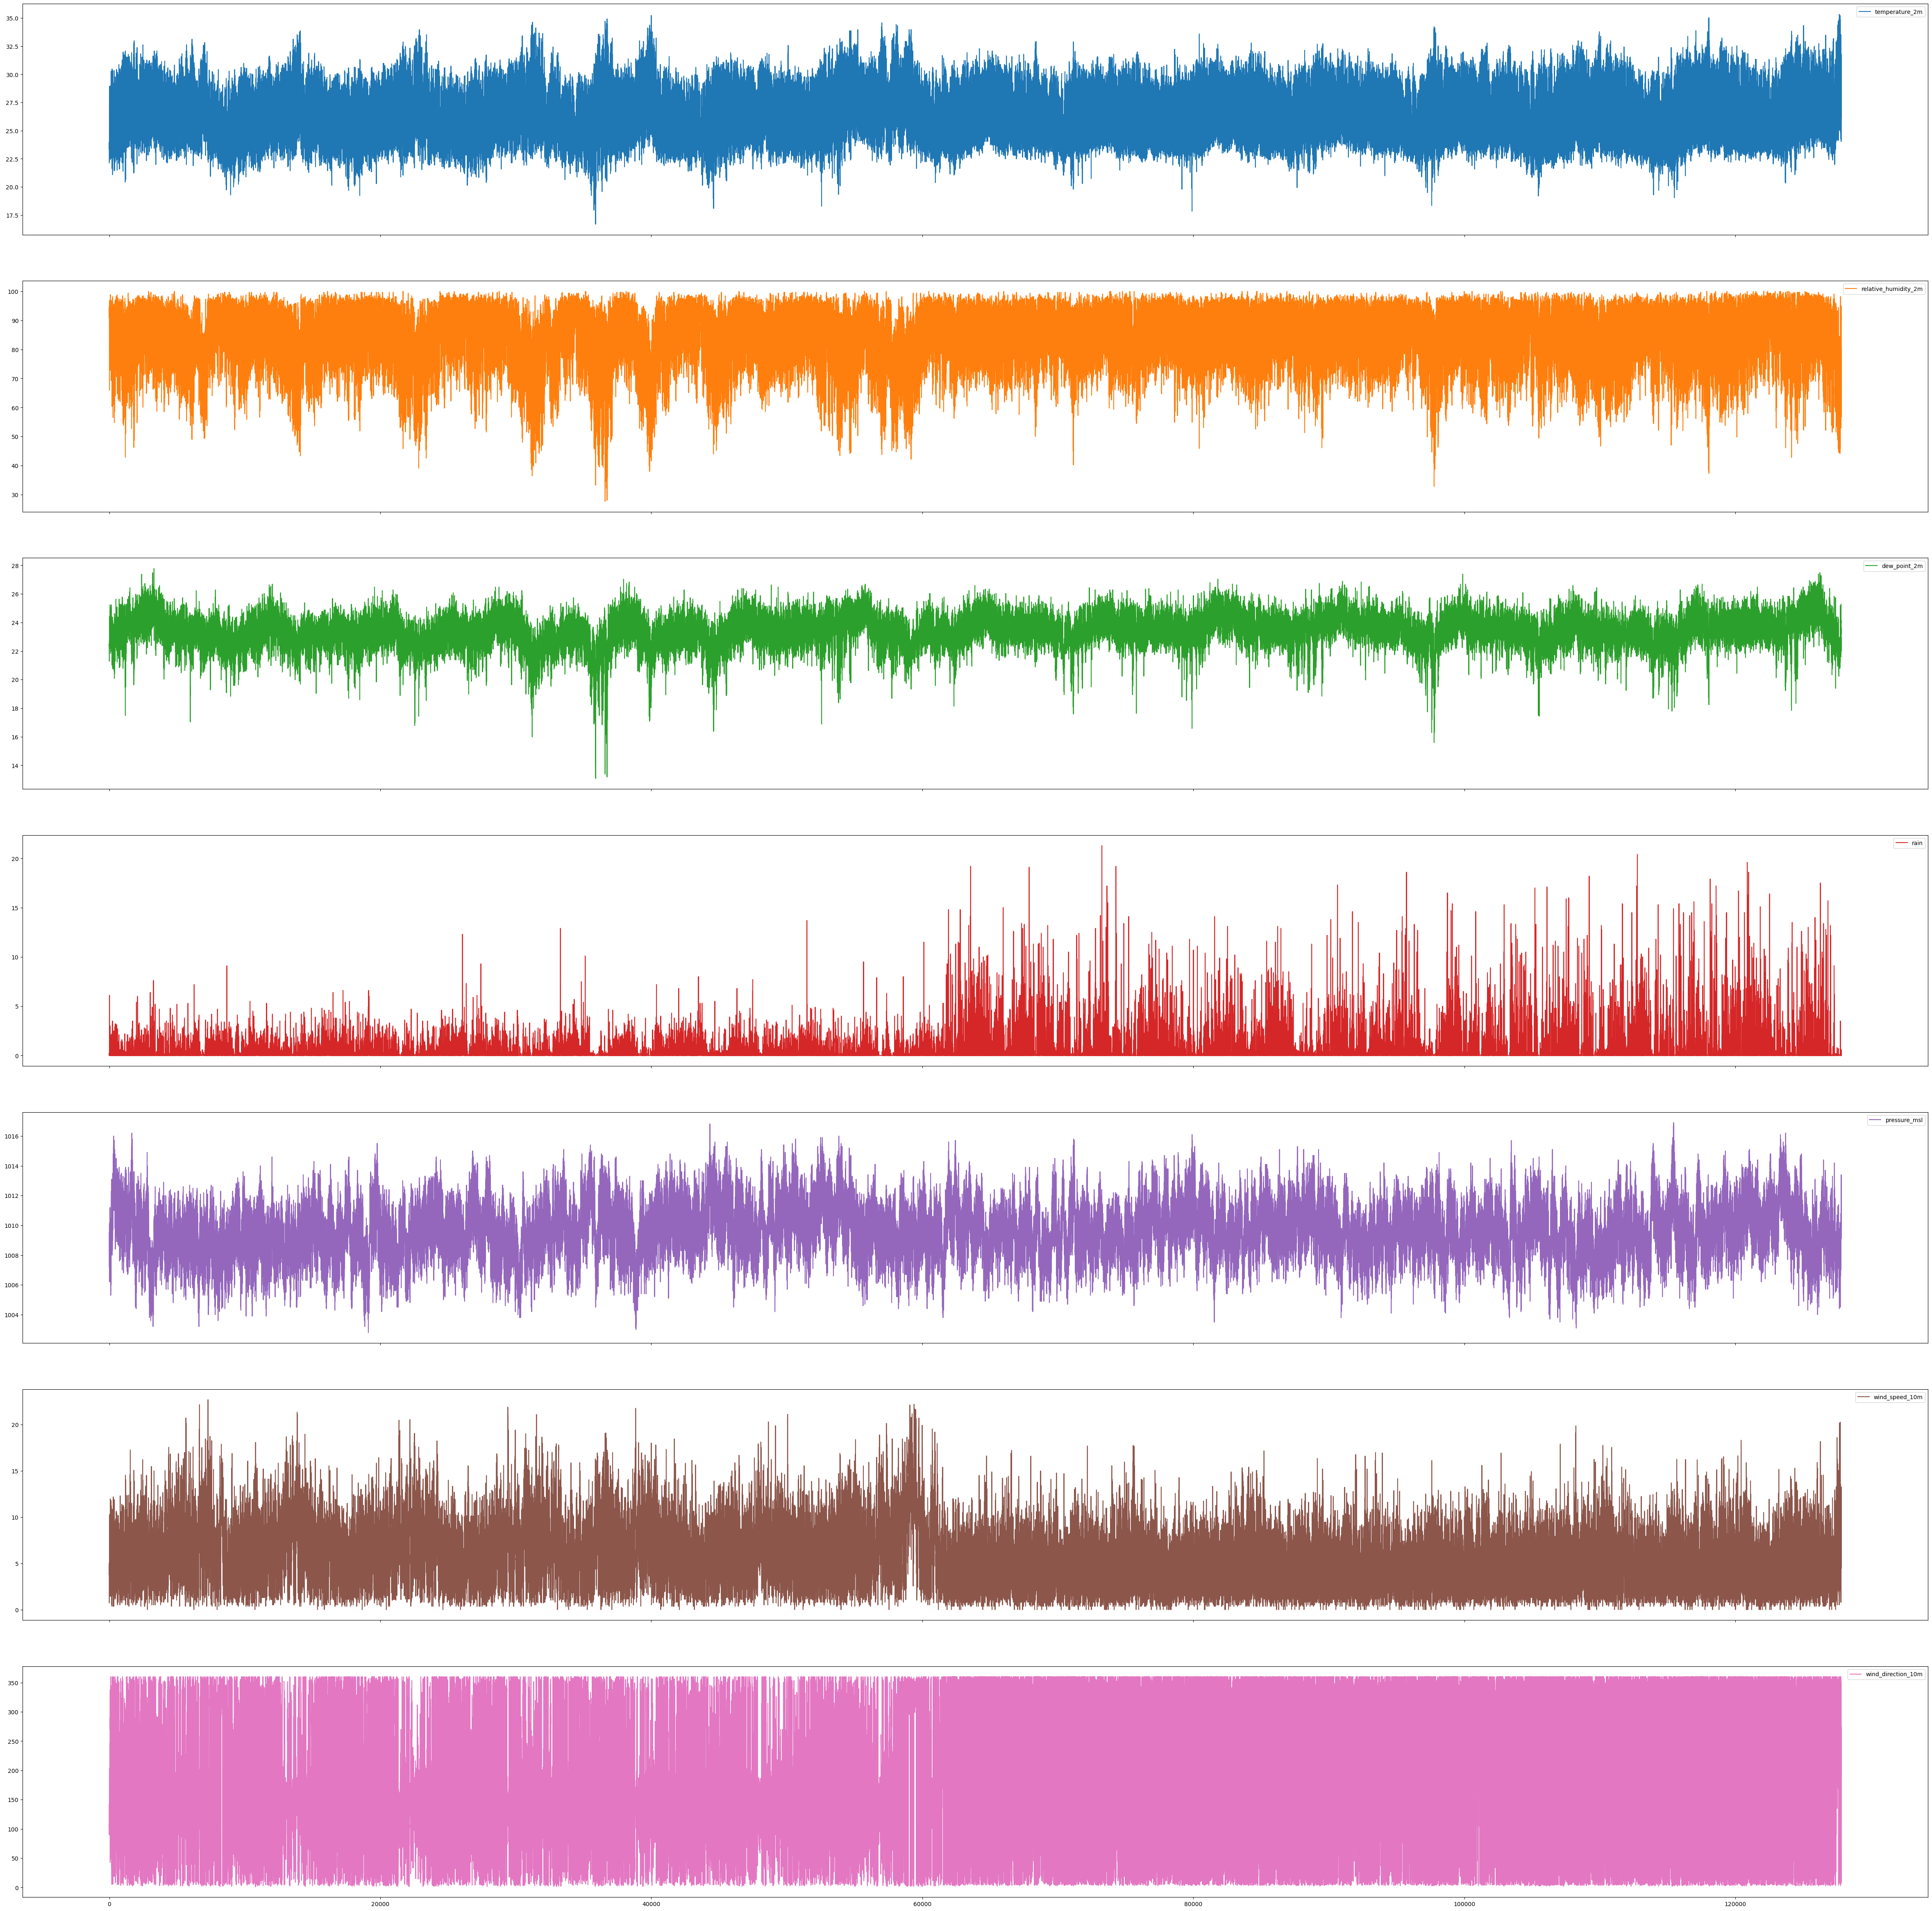

In [4]:
hourly_dataframe[['temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'rain', 'pressure_msl', 'wind_speed_10m', 'wind_direction_10m']].plot(subplots=True, figsize=(60, 60))

In [27]:
# Train Test split of 70-10-20 (train-eval-test) for LSTM training
training_size = int(0.70 * hourly_dataframe.shape[0])  
evaluation_size = int(0.10 * hourly_dataframe.shape[0])
testing_size = hourly_dataframe.shape[0] - training_size - evaluation_size

print("Training Size: ", training_size)
print("Evaluation Size: ", evaluation_size)
print("Testing Size: ", testing_size)
print("Total Size: ", hourly_dataframe.shape[0])

Training Size:  89476
Evaluation Size:  12782
Testing Size:  25566
Total Size:  127824


## Feature Selection Using Correlation Analysis

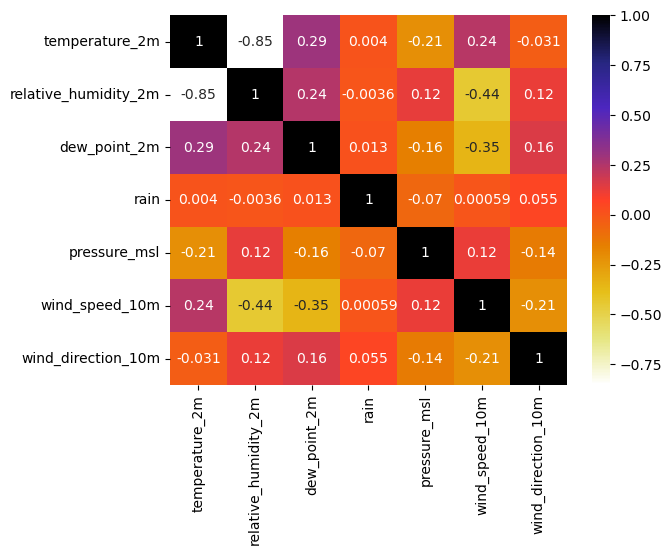

In [28]:
cor = hourly_dataframe.iloc[:training_size].drop(columns=['date']).corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

## Splitting the dataset into the Training set and Test set

In [29]:
# final_hourly_dataframe = hourly_dataframe.drop(columns=['date', 'rain'])
# Set datetime as index
final_hourly_dataframe = hourly_dataframe.set_index('date')

In [8]:
hourly_dataframe.columns

Index(['date', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'rain', 'pressure_msl', 'wind_speed_10m', 'wind_direction_10m'],
      dtype='object')

In [30]:
# Splitting and preparing the train and test dataframes
# Function to convert data into sequences
def make_sequence(data, label_col, window_size =  72):

    sequences = []
    labels = []

    for i in range(data.shape[0] - window_size):
        sequences.append(data[i:i+window_size])
        labels.append(data.iloc[i+window_size])
        
    return np.array(sequences), np.array(labels)

In [31]:
training_dataset = final_hourly_dataframe.iloc[:training_size]
evaluation_dataset = final_hourly_dataframe.iloc[training_size:training_size+evaluation_size]
testing_dataset = final_hourly_dataframe.iloc[training_size+evaluation_size:]

training_dataset.head()

,temperature_2m,relative_humidity_2m,dew_point_2m,rain,pressure_msl,wind_speed_10m,wind_direction_10m
date,,,,,,,
2009-12-31 16:00:00+00:00,24.706501,91.10508,23.1565,0.0,1010.0,5.154416,12.094739
2009-12-31 17:00:00+00:00,24.456501,92.19842,23.1065,0.0,1009.4,6.989935,11.888645
2009-12-31 18:00:00+00:00,24.306500,92.74960,23.0565,0.0,1008.9,8.759178,9.462248
2009-12-31 19:00:00+00:00,24.406500,93.31704,23.2565,0.6,1008.3,8.350138,7.431319
2009-12-31 20:00:00+00:00,24.306500,93.87778,23.2565,0.4,1007.8,8.350138,7.431319


## Feature Scaling

In [32]:
scaler = MinMaxScaler() # Default feature range [0, 1]

# Fit scalar to training dataset
scaled_training_dataset = pd.DataFrame(scaler.fit_transform(training_dataset), columns=training_dataset.columns)


# Scale the evaluation and testing datasets using the same training scaler
scaled_evalutation_dataset = pd.DataFrame(scaler.transform(evaluation_dataset), columns=evaluation_dataset.columns)
scaled_testing_dataset = pd.DataFrame(scaler.transform(testing_dataset), columns=testing_dataset.columns)


scaled_training_dataset.head()

,temperature_2m,relative_humidity_2m,dew_point_2m,rain,pressure_msl,wind_speed_10m,wind_direction_10m
0,0.229586,0.868710,0.638127,0.000000,0.514706,0.195040,0.031026
1,0.212453,0.884848,0.634143,0.000000,0.470588,0.264494,0.030452
2,0.202172,0.892983,0.630159,0.000000,0.433824,0.331441,0.023695
3,0.209026,0.901359,0.646096,0.018634,0.389706,0.315964,0.018038
4,0.202172,0.909635,0.646096,0.012422,0.352941,0.315964,0.018038


In [33]:

# Create sequences for LSTM model for each type of dataset
X_train, y_train = make_sequence(scaled_training_dataset, 'temperature_2m')
X_eval, y_eval = make_sequence(scaled_evalutation_dataset, 'temperature_2m')
X_test, y_test = make_sequence(scaled_testing_dataset, 'temperature_2m')

In [34]:
# Print shapes of training
# Shape for X: (samples, time_steps, features)
# Shape for y: (samples, features)
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_eval shape: ", X_eval.shape)
print("y_eval shape: ", y_eval.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (89404, 72, 7)
y_train shape:  (89404, 7)
X_eval shape:  (12710, 72, 7)
y_eval shape:  (12710, 7)
X_test shape:  (25494, 72, 7)
y_test shape:  (25494, 7)


In [ ]:
# Number of windows from n sized array with k window size, no +1 since we want the next predicted value
# n - k

## Create Model and Train

In [35]:
def create_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=input_shape))
    model.add(LSTM(7)) # Predicting 7 features
    model.compile(optimizer='adam', loss='mse')
    return model

In [36]:
model = create_model((X_train.shape[1], X_train.shape[2]))

In [37]:
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_eval, y_eval), shuffle=False)

Epoch 1/50
1397/1397 [==============================] - 169s 117ms/step - loss: 0.0156 - val_loss: 0.0116
Epoch 2/50
1397/1397 [==============================] - 186s 133ms/step - loss: 0.0079 - val_loss: 0.0099
Epoch 3/50
1397/1397 [==============================] - 164s 117ms/step - loss: 0.0072 - val_loss: 0.0091
Epoch 4/50
1397/1397 [==============================] - 164s 117ms/step - loss: 0.0069 - val_loss: 0.0086
Epoch 5/50
1397/1397 [==============================] - 164s 118ms/step - loss: 0.0068 - val_loss: 0.0083
Epoch 6/50
1397/1397 [==============================] - 164s 117ms/step - loss: 0.0067 - val_loss: 0.0080
Epoch 7/50
1397/1397 [==============================] - 165s 118ms/step - loss: 0.0066 - val_loss: 0.0078
Epoch 8/50
1397/1397 [==============================] - 164s 117ms/step - loss: 0.0065 - val_loss: 0.0077
Epoch 9/50
1397/1397 [==============================] - 165s 118ms/step - loss: 0.0064 - val_loss: 0.0076
Epoch 10/50
1397/1397 [=======================

## Evaluate Model

In [38]:
test_precdictions = model.predict(X_test)

797/797 [==============================] - 22s 26ms/step


In [39]:
print(test_precdictions.shape)
print(test_precdictions[0])

(25494, 7)
[0.45873243 0.6289465  0.64962465 0.01306344 0.30172884 0.21662584
 0.31147504]


In [40]:
# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, test_precdictions)
rmse = np.sqrt(mean_squared_error(y_test, test_precdictions))

print("Test data Mean Absolute Error: ", mae)
print("Test data Root Mean Squared Error: ", rmse)


Test data Mean Absolute Error:  0.04503856889732416
Test data Root Mean Squared Error:  0.09825455893889197


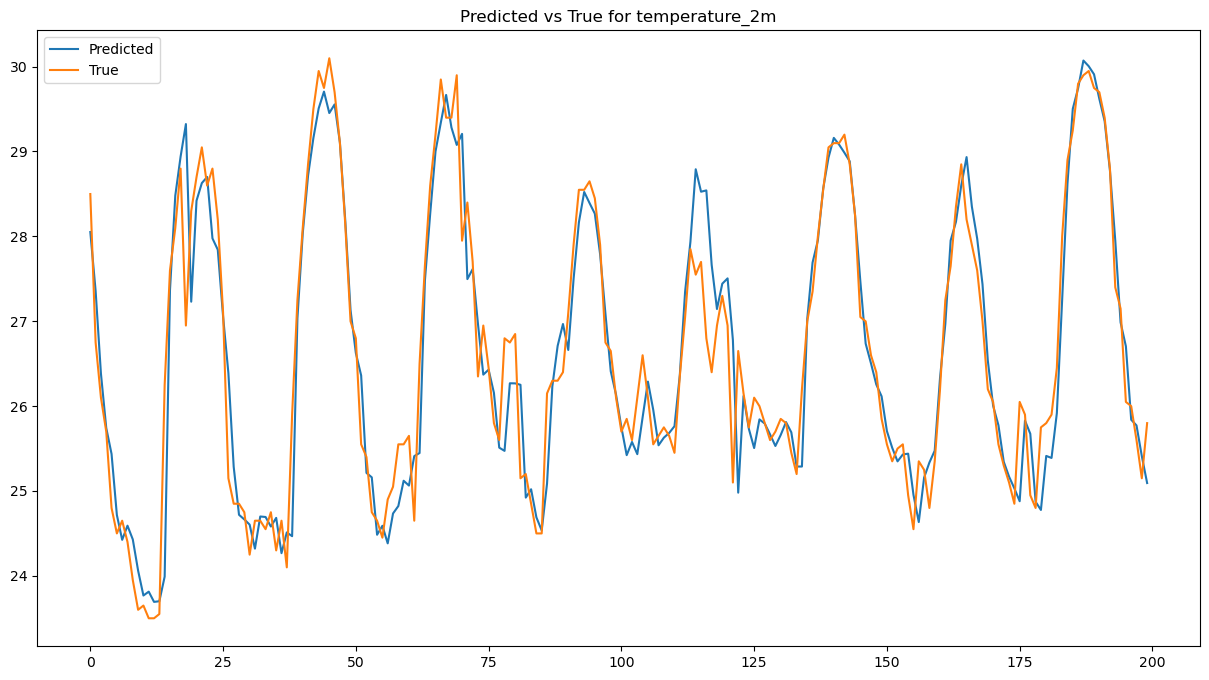

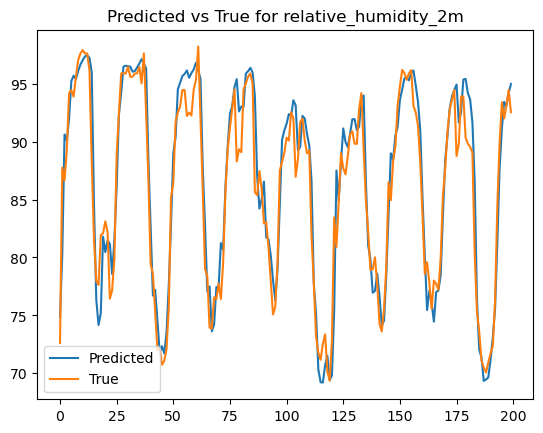

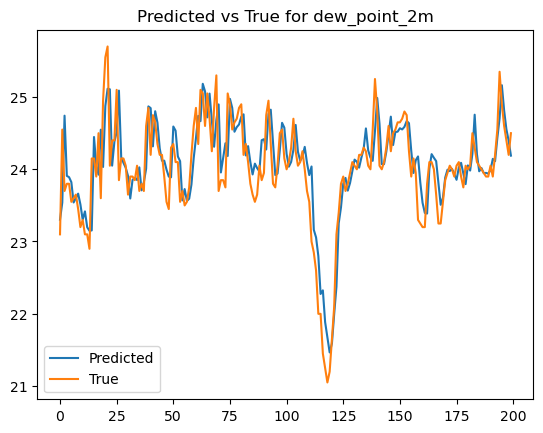

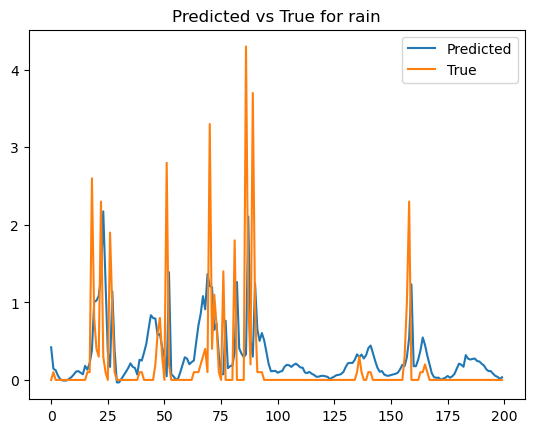

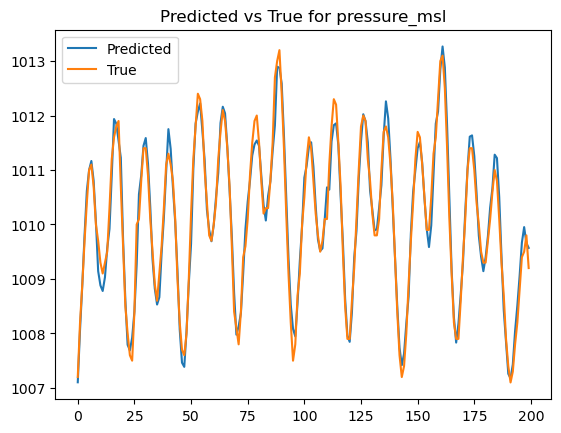

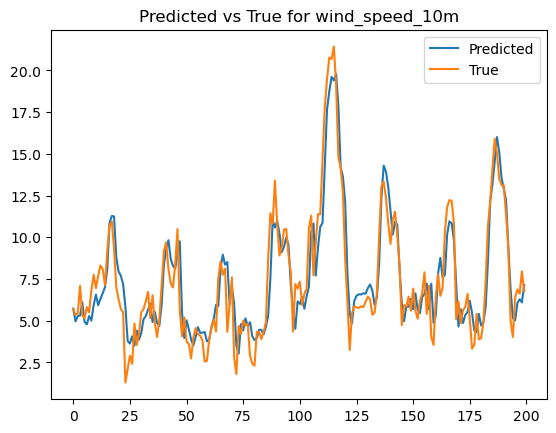

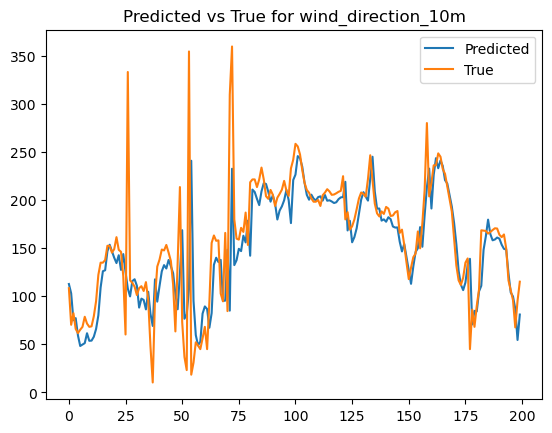

In [41]:
# Inverse transform the predictions and true values
transformed_test_predictions = scaler.inverse_transform(test_precdictions)
transformed_y_test = scaler.inverse_transform(y_test)

# Plot predicted values against true values
plt.figure(figsize=(15, 8))

# Only get the list of columns strings and exclude the first date column
columns = list(hourly_dataframe.columns)[1:]

# Plot for each attribute
for i in range(transformed_y_test.shape[1]):
    plt.plot(transformed_test_predictions[:200, i], label='Predicted')
    plt.plot(transformed_y_test[:200, i], label='True')
    plt.title(f'Predicted vs True for {columns[i]}')
    plt.legend()
    plt.show()

## Export Model and Scaler

In [42]:
model_location = f'../../models/{location_code}/model.h5'
scaler_location = f'../../models/{location_code}/scaler.pkl'


In [43]:
# Save LSTM model
model.save(model_location)

In [44]:
# Save MinMaxScaler object
joblib.dump(scaler, scaler_location)

['../../models/johor-bahru/scaler.pkl']